In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

db = 'chinook.db'

In [3]:
def run_query(sql_query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(sql_query, conn)

In [4]:
def run_command(sql_command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(sql_command)

In [9]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [10]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Write a query that returns each genre in USA, with the number of tracks sold in absolute numbers and in percentages.

In [25]:
q = '''
    WITH 
        invoice_db AS
        (
            SELECT
                invoice_line.invoice_line_id,
                invoice_line.track_id track_id
            FROM invoice_line
            LEFT JOIN invoice
            ON invoice_line.invoice_id = invoice.invoice_id
            LEFT JOIN customer
            ON invoice.customer_id = customer.customer_id
            WHERE customer.country = "USA"
        )

    SELECT
        genre.name genre_type,
        COUNT(invoice_db.track_id) tracks_sold,
        cast(count(invoice_db.track_id) AS FLOAT) / 
        (
            SELECT COUNT(*) from invoice_db
        ) percentage_sold
        
    FROM invoice_db
    LEFT JOIN track
    ON invoice_db.track_id = track.track_id
    LEFT JOIN genre
    ON track.genre_id = genre.genre_id
    GROUP BY genre_type
    ORDER BY tracks_sold DESC
    
    '''
run_query(q)

,genre_type,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


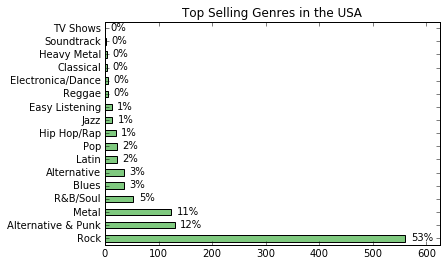

In [27]:
genre_sales_usa = run_query(q)
genre_sales_usa.set_index("genre_type", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

### Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company.

In [32]:
q_agent = '''
    SELECT DISTINCT title
    FROM employee
    '''
run_query(q_agent)

,title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


In [41]:
q_agent_sales = '''
    WITH
        sup_agents AS
        (
            SELECT 
                employee_id e_id,
                first_name || " " || last_name e_name
            FROM employee
            WHERE title = "Sales Support Agent"
        )
    SELECT 
        sup_agents.e_name agent_name,
        SUM(invoice.total) agent_sales
    FROM sup_agents
    LEFT JOIN customer
    ON sup_agents.e_id = customer.support_rep_id
    LEFT JOIN invoice
    ON customer.customer_id = invoice.customer_id
    GROUP BY agent_name 
        
    '''
run_query(q_agent_sales)

,agent_name,agent_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


###  Write a query that collates data on purchases from different countries. For each country, include:
- total number of customers,
- total value of sales,
- average value of sales per customer,
- average order value,

In [58]:
q_purchase_per_country = '''
    WITH
        country_customers AS
        (
            SELECT 
                customer.customer_id,
                customer.country,
                invoice.total tot_purch,
                invoice.invoice_id inv
            FROM customer
            LEFT JOIN invoice
            ON customer.customer_id = invoice.customer_id
        )
    SELECT 
        country_customers.country country,
        COUNT(distinct country_customers.customer_id) tot_no_of_customers,
        SUM(country_customers.tot_purch) tot_sales,
        (SUM(country_customers.tot_purch) / COUNT(distinct country_customers.customer_id))
            avg_sale_per_customer, 
        (SUM(country_customers.tot_purch) / COUNT(distinct country_customers.inv))
            avg_order_value
    FROM country_customers

    GROUP BY country 
    ORDER BY 3 DESC
        
    '''
run_query(q_purchase_per_country)

,country,tot_no_of_customers,tot_sales,avg_sale_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Ireland,1,114.84,114.840000,8.833846


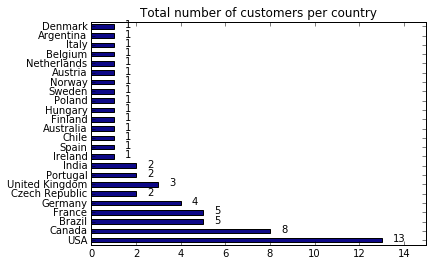

In [66]:
countries = run_query(q_purchase_per_country)
countries.set_index("country", inplace=True, drop=True)

countries["tot_no_of_customers"].plot.barh(
    title="Total number of customers per country",
    xlim=(0, 15),
    colormap=plt.cm.plasma
)

plt.ylabel('')

for i, label in enumerate(list(countries.index)):
    score = countries.loc[label, "tot_no_of_customers"]
    label = countries.loc[label, "tot_no_of_customers"] 
    plt.annotate(str(label), (score +0.5 , i - 0.15))

plt.show()

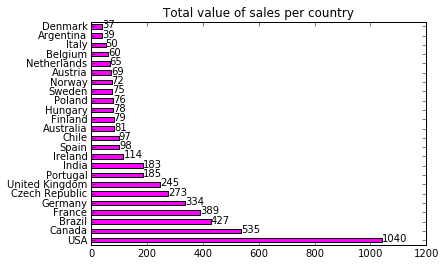

In [75]:
countries = run_query(q_purchase_per_country)
countries.set_index("country", inplace=True, drop=True)

countries["tot_sales"].plot.barh(
    title="Total value of sales per country",
    xlim=(0, 1200),
    colormap=plt.cm.spring
)

plt.ylabel('')

for i, label in enumerate(list(countries.index)):
    score = countries.loc[label, "tot_sales"].astype(int)
    label = countries.loc[label, "tot_sales"].astype(int)
    plt.annotate(str(label), (score +0.5 , i - 0.15))

plt.show()

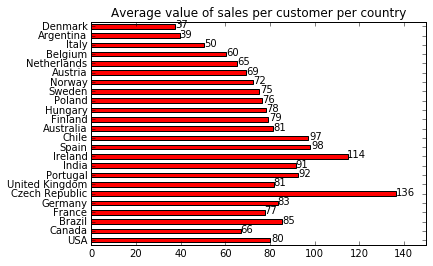

In [77]:
countries = run_query(q_purchase_per_country)
countries.set_index("country", inplace=True, drop=True)

countries["avg_sale_per_customer"].plot.barh(
    title="Average value of sales per customer per country",
    xlim=(0, 150),
    colormap=plt.cm.autumn
)

plt.ylabel('')

for i, label in enumerate(list(countries.index)):
    score = countries.loc[label, "avg_sale_per_customer"].astype(int)
    label = countries.loc[label, "avg_sale_per_customer"].astype(int)
    plt.annotate(str(label), (score +0.5 , i - 0.15))

plt.show()

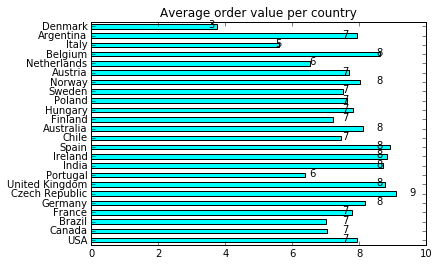

In [81]:
countries = run_query(q_purchase_per_country)
countries.set_index("country", inplace=True, drop=True)

countries["avg_order_value"].plot.barh(
    title="Average order value per country",
    xlim=(0, 10),
    colormap=plt.cm.cool
)

plt.ylabel('')

for i, label in enumerate(list(countries.index)):
    score = countries.loc[label, "avg_order_value"].astype(int)
    label = countries.loc[label, "avg_order_value"].astype(int)
    plt.annotate(str(label), (score +0.5 , i - 0.15))

plt.show()